In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from preprocess.BaselinePrerocess import baseline_process
from baselines.rnn import rnn

2023-07-29 23:48:51.491316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 23:48:53.007510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [6]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
rnn_unit = 64
l1_reg = 1e-5
l2_reg = 1e-5
dropout = 0.2


learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [9]:
model = rnn(input_shape=input_shape,
            rnn_unit=rnn_unit,
            l1_reg=l1_reg, 
            l2_reg=l2_reg, 
            dropout=dropout,
            masked_value=masked_value
            )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking_1 (Masking)         (None, 96, 16)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 96, 64)            5184      
                                                                 
 dropout_1 (Dropout)         (None, 96, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dense_1 (Dense)             (None, 96)                589920    
                                                                 
Total params: 595104 (2.27 MB)
Trainable params: 595104 (2.

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../saved_models/WaLeF_rnn.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X_mask, train_ws_y,
          validation_data=(test_X_mask, test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-29 23:49:16.900179: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7808002580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-29 23:49:16.900230: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-29 23:49:16.911042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-29 23:49:17.149403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-29 23:49:17.597471: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.06231, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 17s - loss: 0.0254 - mae: 0.1008 - val_loss: 0.0125 - val_mae: 0.0623 - 17s/epoch - 114ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.06231 to 0.05434, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 0.0127 - mae: 0.0632 - val_loss: 0.0106 - val_mae: 0.0543 - 13s/epoch - 88ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.05434 to 0.05009, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 0.0104 - mae: 0.0527 - val_loss: 0.0096 - val_mae: 0.0501 - 13s/epoch - 86ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.05009 to 0.04626, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 0.0090 - mae: 0.0455 - val_loss: 0.0088 - val_mae: 0.0463 - 13s/epoch - 85ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.04626 to 0.04355, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 0.0080 - mae: 0.0400 - val_loss: 0.0082 - val_mae: 0.0436 - 13s/epoch - 85ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.04355 to 0.04213, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 0.0072 - mae: 0.0356 - va

151/151 - 13s - loss: 0.0010 - mae: 0.0130 - val_loss: 0.0016 - val_mae: 0.0241 - 13s/epoch - 84ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.02407 to 0.02375, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 9.5301e-04 - mae: 0.0129 - val_loss: 0.0015 - val_mae: 0.0238 - 13s/epoch - 84ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.02375 to 0.02342, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 9.0376e-04 - mae: 0.0128 - val_loss: 0.0015 - val_mae: 0.0234 - 13s/epoch - 83ms/step
Epoch 44/3000

Epoch 44: val_mae improved from 0.02342 to 0.02308, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 12s - loss: 8.5949e-04 - mae: 0.0127 - val_loss: 0.0014 - val_mae: 0.0231 - 12s/epoch - 83ms/step
Epoch 45/3000

Epoch 45: val_mae improved from 0.02308 to 0.02252, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 8.1538e-04 - mae: 0.0126 - val_loss: 0.0013 - val_mae: 0.0225 - 13s/epoch - 84ms/step
Epoch 46/3000

E

151/151 - 13s - loss: 3.7082e-04 - mae: 0.0108 - val_loss: 7.2168e-04 - val_mae: 0.0188 - 13s/epoch - 85ms/step
Epoch 84/3000

Epoch 84: val_mae did not improve from 0.01850
151/151 - 13s - loss: 3.6738e-04 - mae: 0.0108 - val_loss: 7.0315e-04 - val_mae: 0.0185 - 13s/epoch - 84ms/step
Epoch 85/3000

Epoch 85: val_mae did not improve from 0.01850
151/151 - 13s - loss: 3.6594e-04 - mae: 0.0108 - val_loss: 7.3237e-04 - val_mae: 0.0190 - 13s/epoch - 83ms/step
Epoch 86/3000

Epoch 86: val_mae improved from 0.01850 to 0.01833, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 3.6264e-04 - mae: 0.0107 - val_loss: 6.9001e-04 - val_mae: 0.0183 - 13s/epoch - 84ms/step
Epoch 87/3000

Epoch 87: val_mae improved from 0.01833 to 0.01824, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 3.6107e-04 - mae: 0.0107 - val_loss: 6.7669e-04 - val_mae: 0.0182 - 13s/epoch - 86ms/step
Epoch 88/3000

Epoch 88: val_mae did not improve from 0.01824
151/151 - 13s - loss: 3.5925e-

Epoch 126/3000

Epoch 126: val_mae did not improve from 0.01610
151/151 - 12s - loss: 3.0336e-04 - mae: 0.0101 - val_loss: 5.4400e-04 - val_mae: 0.0163 - 12s/epoch - 82ms/step
Epoch 127/3000

Epoch 127: val_mae did not improve from 0.01610
151/151 - 12s - loss: 3.0207e-04 - mae: 0.0100 - val_loss: 5.5861e-04 - val_mae: 0.0167 - 12s/epoch - 82ms/step
Epoch 128/3000

Epoch 128: val_mae improved from 0.01610 to 0.01595, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 12s - loss: 3.0169e-04 - mae: 0.0101 - val_loss: 5.2429e-04 - val_mae: 0.0160 - 12s/epoch - 82ms/step
Epoch 129/3000

Epoch 129: val_mae did not improve from 0.01595
151/151 - 13s - loss: 3.0096e-04 - mae: 0.0100 - val_loss: 5.3834e-04 - val_mae: 0.0162 - 13s/epoch - 83ms/step
Epoch 130/3000

Epoch 130: val_mae did not improve from 0.01595
151/151 - 13s - loss: 2.9981e-04 - mae: 0.0100 - val_loss: 5.4008e-04 - val_mae: 0.0162 - 13s/epoch - 84ms/step
Epoch 131/3000

Epoch 131: val_mae improved from 0.01595 to 0.01582, s

151/151 - 12s - loss: 2.7366e-04 - mae: 0.0098 - val_loss: 4.3775e-04 - val_mae: 0.0144 - 12s/epoch - 83ms/step
Epoch 170/3000

Epoch 170: val_mae did not improve from 0.01434
151/151 - 13s - loss: 2.7264e-04 - mae: 0.0097 - val_loss: 4.3544e-04 - val_mae: 0.0144 - 13s/epoch - 84ms/step
Epoch 171/3000

Epoch 171: val_mae did not improve from 0.01434
151/151 - 13s - loss: 2.7226e-04 - mae: 0.0097 - val_loss: 4.4438e-04 - val_mae: 0.0145 - 13s/epoch - 86ms/step
Epoch 172/3000

Epoch 172: val_mae did not improve from 0.01434
151/151 - 13s - loss: 2.7196e-04 - mae: 0.0097 - val_loss: 4.4348e-04 - val_mae: 0.0145 - 13s/epoch - 85ms/step
Epoch 173/3000

Epoch 173: val_mae improved from 0.01434 to 0.01424, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 2.7149e-04 - mae: 0.0097 - val_loss: 4.2877e-04 - val_mae: 0.0142 - 13s/epoch - 84ms/step
Epoch 174/3000

Epoch 174: val_mae did not improve from 0.01424
151/151 - 13s - loss: 2.7153e-04 - mae: 0.0097 - val_loss: 4.5063e-04 

Epoch 215/3000

Epoch 215: val_mae did not improve from 0.01368
151/151 - 13s - loss: 2.5585e-04 - mae: 0.0096 - val_loss: 4.0376e-04 - val_mae: 0.0138 - 13s/epoch - 83ms/step
Epoch 216/3000

Epoch 216: val_mae did not improve from 0.01368
151/151 - 13s - loss: 2.5541e-04 - mae: 0.0096 - val_loss: 4.0778e-04 - val_mae: 0.0139 - 13s/epoch - 84ms/step
Epoch 217/3000

Epoch 217: val_mae improved from 0.01368 to 0.01361, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 2.5484e-04 - mae: 0.0096 - val_loss: 3.9460e-04 - val_mae: 0.0136 - 13s/epoch - 84ms/step
Epoch 218/3000

Epoch 218: val_mae did not improve from 0.01361
151/151 - 13s - loss: 2.5501e-04 - mae: 0.0096 - val_loss: 4.2888e-04 - val_mae: 0.0143 - 13s/epoch - 85ms/step
Epoch 219/3000

Epoch 219: val_mae improved from 0.01361 to 0.01348, saving model to ../saved_models/WaLeF_rnn.h5
151/151 - 13s - loss: 2.5493e-04 - mae: 0.0096 - val_loss: 3.8695e-04 - val_mae: 0.0135 - 13s/epoch - 84ms/step
Epoch 220/3000

Epoc

Epoch 261/3000

Epoch 261: val_mae did not improve from 0.01344
151/151 - 12s - loss: 2.4433e-04 - mae: 0.0094 - val_loss: 3.9437e-04 - val_mae: 0.0137 - 12s/epoch - 82ms/step
Epoch 262/3000

Epoch 262: val_mae did not improve from 0.01344
151/151 - 13s - loss: 2.4409e-04 - mae: 0.0094 - val_loss: 3.8407e-04 - val_mae: 0.0136 - 13s/epoch - 85ms/step
Epoch 263/3000

Epoch 263: val_mae did not improve from 0.01344
151/151 - 13s - loss: 2.4401e-04 - mae: 0.0094 - val_loss: 3.9275e-04 - val_mae: 0.0137 - 13s/epoch - 88ms/step
Epoch 264/3000

Epoch 264: val_mae did not improve from 0.01344
151/151 - 13s - loss: 2.4387e-04 - mae: 0.0094 - val_loss: 3.9479e-04 - val_mae: 0.0137 - 13s/epoch - 85ms/step
Epoch 265/3000

Epoch 265: val_mae did not improve from 0.01344
151/151 - 12s - loss: 2.4368e-04 - mae: 0.0094 - val_loss: 3.9252e-04 - val_mae: 0.0137 - 12s/epoch - 83ms/step
Epoch 266/3000

Epoch 266: val_mae did not improve from 0.01344
151/151 - 12s - loss: 2.4320e-04 - mae: 0.0094 - val_los

Epoch 307/3000

Epoch 307: val_mae did not improve from 0.01324
151/151 - 13s - loss: 2.3636e-04 - mae: 0.0094 - val_loss: 3.8845e-04 - val_mae: 0.0138 - 13s/epoch - 84ms/step
Epoch 308/3000

Epoch 308: val_mae did not improve from 0.01324
151/151 - 13s - loss: 2.3659e-04 - mae: 0.0094 - val_loss: 3.8324e-04 - val_mae: 0.0137 - 13s/epoch - 83ms/step
Epoch 309/3000

Epoch 309: val_mae did not improve from 0.01324
151/151 - 13s - loss: 2.3660e-04 - mae: 0.0094 - val_loss: 3.7393e-04 - val_mae: 0.0134 - 13s/epoch - 84ms/step
Epoch 310/3000

Epoch 310: val_mae did not improve from 0.01324
151/151 - 13s - loss: 2.3584e-04 - mae: 0.0094 - val_loss: 3.8397e-04 - val_mae: 0.0137 - 13s/epoch - 83ms/step
Epoch 311/3000

Epoch 311: val_mae did not improve from 0.01324
151/151 - 12s - loss: 2.3553e-04 - mae: 0.0093 - val_loss: 3.6688e-04 - val_mae: 0.0133 - 12s/epoch - 82ms/step
Epoch 312/3000

Epoch 312: val_mae did not improve from 0.01324
151/151 - 13s - loss: 2.3584e-04 - mae: 0.0094 - val_los

Epoch 353/3000

Epoch 353: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.3056e-04 - mae: 0.0093 - val_loss: 3.6853e-04 - val_mae: 0.0135 - 13s/epoch - 84ms/step
Epoch 354/3000

Epoch 354: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.3067e-04 - mae: 0.0093 - val_loss: 3.6383e-04 - val_mae: 0.0133 - 13s/epoch - 84ms/step
Epoch 355/3000

Epoch 355: val_mae did not improve from 0.01306
151/151 - 12s - loss: 2.3022e-04 - mae: 0.0093 - val_loss: 3.6707e-04 - val_mae: 0.0134 - 12s/epoch - 83ms/step
Epoch 356/3000

Epoch 356: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.3031e-04 - mae: 0.0093 - val_loss: 3.5303e-04 - val_mae: 0.0131 - 13s/epoch - 85ms/step
Epoch 357/3000

Epoch 357: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.3015e-04 - mae: 0.0093 - val_loss: 3.6412e-04 - val_mae: 0.0133 - 13s/epoch - 85ms/step
Epoch 358/3000

Epoch 358: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.3090e-04 - mae: 0.0093 - val_los

Epoch 400/3000

Epoch 400: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.2616e-04 - mae: 0.0092 - val_loss: 3.5167e-04 - val_mae: 0.0131 - 13s/epoch - 83ms/step
Epoch 401/3000

Epoch 401: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.2566e-04 - mae: 0.0092 - val_loss: 3.5769e-04 - val_mae: 0.0133 - 13s/epoch - 84ms/step
Epoch 402/3000

Epoch 402: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.2627e-04 - mae: 0.0093 - val_loss: 3.5364e-04 - val_mae: 0.0132 - 13s/epoch - 85ms/step
Epoch 403/3000

Epoch 403: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.2497e-04 - mae: 0.0092 - val_loss: 3.5161e-04 - val_mae: 0.0132 - 13s/epoch - 86ms/step
Epoch 404/3000

Epoch 404: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.2542e-04 - mae: 0.0092 - val_loss: 3.6415e-04 - val_mae: 0.0134 - 13s/epoch - 85ms/step
Epoch 405/3000

Epoch 405: val_mae did not improve from 0.01306
151/151 - 13s - loss: 2.2570e-04 - mae: 0.0092 - val_los

151/151 - 13s - loss: 2.2227e-04 - mae: 0.0092 - val_loss: 3.5598e-04 - val_mae: 0.0133 - 13s/epoch - 85ms/step
Epoch 447/3000

Epoch 447: val_mae did not improve from 0.01305
151/151 - 13s - loss: 2.2268e-04 - mae: 0.0092 - val_loss: 3.5200e-04 - val_mae: 0.0132 - 13s/epoch - 86ms/step
Epoch 448/3000

Epoch 448: val_mae did not improve from 0.01305
151/151 - 13s - loss: 2.2208e-04 - mae: 0.0092 - val_loss: 3.8238e-04 - val_mae: 0.0139 - 13s/epoch - 84ms/step
Epoch 449/3000

Epoch 449: val_mae did not improve from 0.01305
151/151 - 13s - loss: 2.2191e-04 - mae: 0.0092 - val_loss: 3.8014e-04 - val_mae: 0.0138 - 13s/epoch - 84ms/step
Epoch 450/3000

Epoch 450: val_mae did not improve from 0.01305
151/151 - 13s - loss: 2.2199e-04 - mae: 0.0092 - val_loss: 3.6611e-04 - val_mae: 0.0135 - 13s/epoch - 85ms/step
Epoch 451/3000

Epoch 451: val_mae did not improve from 0.01305
151/151 - 13s - loss: 2.2154e-04 - mae: 0.0092 - val_loss: 3.8534e-04 - val_mae: 0.0139 - 13s/epoch - 86ms/step
Epoch 45

Epoch 493/3000

Epoch 493: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1926e-04 - mae: 0.0092 - val_loss: 3.5083e-04 - val_mae: 0.0132 - 13s/epoch - 85ms/step
Epoch 494/3000

Epoch 494: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1878e-04 - mae: 0.0091 - val_loss: 3.5843e-04 - val_mae: 0.0134 - 13s/epoch - 85ms/step
Epoch 495/3000

Epoch 495: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1934e-04 - mae: 0.0092 - val_loss: 3.5713e-04 - val_mae: 0.0134 - 13s/epoch - 83ms/step
Epoch 496/3000

Epoch 496: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1931e-04 - mae: 0.0092 - val_loss: 3.4911e-04 - val_mae: 0.0132 - 13s/epoch - 84ms/step
Epoch 497/3000

Epoch 497: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1924e-04 - mae: 0.0092 - val_loss: 3.6019e-04 - val_mae: 0.0134 - 13s/epoch - 84ms/step
Epoch 498/3000

Epoch 498: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1912e-04 - mae: 0.0092 - val_los

Epoch 540/3000

Epoch 540: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1646e-04 - mae: 0.0091 - val_loss: 3.5572e-04 - val_mae: 0.0134 - 13s/epoch - 84ms/step
Epoch 541/3000

Epoch 541: val_mae did not improve from 0.01298
151/151 - 14s - loss: 2.1649e-04 - mae: 0.0091 - val_loss: 3.5591e-04 - val_mae: 0.0134 - 14s/epoch - 91ms/step
Epoch 542/3000

Epoch 542: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1646e-04 - mae: 0.0091 - val_loss: 3.6456e-04 - val_mae: 0.0136 - 13s/epoch - 85ms/step
Epoch 543/3000

Epoch 543: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1680e-04 - mae: 0.0091 - val_loss: 3.4783e-04 - val_mae: 0.0132 - 13s/epoch - 86ms/step
Epoch 544/3000

Epoch 544: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1661e-04 - mae: 0.0091 - val_loss: 3.5435e-04 - val_mae: 0.0133 - 13s/epoch - 83ms/step
Epoch 545/3000

Epoch 545: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1635e-04 - mae: 0.0091 - val_los

Epoch 587/3000

Epoch 587: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1461e-04 - mae: 0.0091 - val_loss: 3.5094e-04 - val_mae: 0.0133 - 13s/epoch - 83ms/step
Epoch 588/3000

Epoch 588: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1477e-04 - mae: 0.0091 - val_loss: 3.6134e-04 - val_mae: 0.0135 - 13s/epoch - 84ms/step
Epoch 589/3000

Epoch 589: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1440e-04 - mae: 0.0091 - val_loss: 3.6319e-04 - val_mae: 0.0136 - 13s/epoch - 84ms/step
Epoch 590/3000

Epoch 590: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1433e-04 - mae: 0.0091 - val_loss: 3.6490e-04 - val_mae: 0.0136 - 13s/epoch - 83ms/step
Epoch 591/3000

Epoch 591: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1452e-04 - mae: 0.0091 - val_loss: 3.5332e-04 - val_mae: 0.0134 - 13s/epoch - 84ms/step
Epoch 592/3000

Epoch 592: val_mae did not improve from 0.01298
151/151 - 13s - loss: 2.1428e-04 - mae: 0.0091 - val_los

151/151 - 13s - loss: 2.1277e-04 - mae: 0.0091 - val_loss: 3.6346e-04 - val_mae: 0.0136 - 13s/epoch - 84ms/step
Epoch 634/3000

Epoch 634: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1302e-04 - mae: 0.0091 - val_loss: 3.6319e-04 - val_mae: 0.0136 - 13s/epoch - 84ms/step
Epoch 635/3000

Epoch 635: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1340e-04 - mae: 0.0091 - val_loss: 3.7239e-04 - val_mae: 0.0138 - 13s/epoch - 86ms/step
Epoch 636/3000

Epoch 636: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1279e-04 - mae: 0.0091 - val_loss: 3.6327e-04 - val_mae: 0.0136 - 13s/epoch - 84ms/step
Epoch 637/3000

Epoch 637: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1274e-04 - mae: 0.0091 - val_loss: 3.6590e-04 - val_mae: 0.0137 - 13s/epoch - 84ms/step
Epoch 638/3000

Epoch 638: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1241e-04 - mae: 0.0091 - val_loss: 3.5731e-04 - val_mae: 0.0135 - 13s/epoch - 85ms/step
Epoch 63

Epoch 680/3000

Epoch 680: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1122e-04 - mae: 0.0091 - val_loss: 3.7252e-04 - val_mae: 0.0138 - 13s/epoch - 88ms/step
Epoch 681/3000

Epoch 681: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1075e-04 - mae: 0.0090 - val_loss: 3.7013e-04 - val_mae: 0.0138 - 13s/epoch - 87ms/step
Epoch 682/3000

Epoch 682: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1117e-04 - mae: 0.0091 - val_loss: 3.6025e-04 - val_mae: 0.0136 - 13s/epoch - 88ms/step
Epoch 683/3000

Epoch 683: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1145e-04 - mae: 0.0091 - val_loss: 3.5466e-04 - val_mae: 0.0134 - 13s/epoch - 88ms/step
Epoch 684/3000

Epoch 684: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1161e-04 - mae: 0.0091 - val_loss: 3.5974e-04 - val_mae: 0.0136 - 13s/epoch - 87ms/step
Epoch 685/3000

Epoch 685: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1128e-04 - mae: 0.0091 - val_los

Epoch 727/3000

Epoch 727: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0986e-04 - mae: 0.0090 - val_loss: 3.5324e-04 - val_mae: 0.0134 - 13s/epoch - 87ms/step
Epoch 728/3000

Epoch 728: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0976e-04 - mae: 0.0090 - val_loss: 3.6489e-04 - val_mae: 0.0137 - 13s/epoch - 88ms/step
Epoch 729/3000

Epoch 729: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1016e-04 - mae: 0.0090 - val_loss: 3.4964e-04 - val_mae: 0.0133 - 13s/epoch - 87ms/step
Epoch 730/3000

Epoch 730: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0961e-04 - mae: 0.0090 - val_loss: 3.3818e-04 - val_mae: 0.0131 - 13s/epoch - 86ms/step
Epoch 731/3000

Epoch 731: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1034e-04 - mae: 0.0091 - val_loss: 3.4456e-04 - val_mae: 0.0132 - 13s/epoch - 86ms/step
Epoch 732/3000

Epoch 732: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.1004e-04 - mae: 0.0090 - val_los

Epoch 774/3000

Epoch 774: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0897e-04 - mae: 0.0090 - val_loss: 3.6797e-04 - val_mae: 0.0138 - 13s/epoch - 85ms/step
Epoch 775/3000

Epoch 775: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0843e-04 - mae: 0.0090 - val_loss: 3.5933e-04 - val_mae: 0.0136 - 13s/epoch - 86ms/step
Epoch 776/3000

Epoch 776: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0870e-04 - mae: 0.0090 - val_loss: 3.6518e-04 - val_mae: 0.0137 - 13s/epoch - 87ms/step
Epoch 777/3000

Epoch 777: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0945e-04 - mae: 0.0091 - val_loss: 3.8310e-04 - val_mae: 0.0141 - 13s/epoch - 88ms/step
Epoch 778/3000

Epoch 778: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0884e-04 - mae: 0.0090 - val_loss: 3.6939e-04 - val_mae: 0.0138 - 13s/epoch - 87ms/step
Epoch 779/3000

Epoch 779: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0810e-04 - mae: 0.0090 - val_los

Epoch 821/3000

Epoch 821: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0833e-04 - mae: 0.0090 - val_loss: 3.6544e-04 - val_mae: 0.0137 - 13s/epoch - 88ms/step
Epoch 822/3000

Epoch 822: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0785e-04 - mae: 0.0090 - val_loss: 3.5636e-04 - val_mae: 0.0135 - 13s/epoch - 88ms/step
Epoch 823/3000

Epoch 823: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0768e-04 - mae: 0.0090 - val_loss: 3.3701e-04 - val_mae: 0.0131 - 13s/epoch - 88ms/step
Epoch 824/3000

Epoch 824: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0756e-04 - mae: 0.0090 - val_loss: 3.4933e-04 - val_mae: 0.0134 - 13s/epoch - 87ms/step
Epoch 825/3000

Epoch 825: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0795e-04 - mae: 0.0090 - val_loss: 3.7525e-04 - val_mae: 0.0140 - 13s/epoch - 86ms/step
Epoch 826/3000

Epoch 826: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0788e-04 - mae: 0.0090 - val_los

Epoch 868/3000

Epoch 868: val_mae did not improve from 0.01292
151/151 - 14s - loss: 2.0704e-04 - mae: 0.0090 - val_loss: 3.5876e-04 - val_mae: 0.0136 - 14s/epoch - 91ms/step
Epoch 869/3000

Epoch 869: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0718e-04 - mae: 0.0090 - val_loss: 3.5228e-04 - val_mae: 0.0134 - 13s/epoch - 89ms/step
Epoch 870/3000

Epoch 870: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0721e-04 - mae: 0.0090 - val_loss: 3.5571e-04 - val_mae: 0.0135 - 13s/epoch - 87ms/step
Epoch 871/3000

Epoch 871: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0640e-04 - mae: 0.0090 - val_loss: 3.5999e-04 - val_mae: 0.0136 - 13s/epoch - 87ms/step
Epoch 872/3000

Epoch 872: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0748e-04 - mae: 0.0090 - val_loss: 3.6655e-04 - val_mae: 0.0138 - 13s/epoch - 88ms/step
Epoch 873/3000

Epoch 873: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0683e-04 - mae: 0.0090 - val_los

Epoch 915/3000

Epoch 915: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0592e-04 - mae: 0.0090 - val_loss: 3.5504e-04 - val_mae: 0.0135 - 13s/epoch - 85ms/step
Epoch 916/3000

Epoch 916: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0617e-04 - mae: 0.0090 - val_loss: 3.4997e-04 - val_mae: 0.0134 - 13s/epoch - 87ms/step
Epoch 917/3000

Epoch 917: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0610e-04 - mae: 0.0090 - val_loss: 3.5022e-04 - val_mae: 0.0134 - 13s/epoch - 87ms/step
Epoch 918/3000

Epoch 918: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0599e-04 - mae: 0.0090 - val_loss: 3.7203e-04 - val_mae: 0.0140 - 13s/epoch - 86ms/step
Epoch 919/3000

Epoch 919: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0632e-04 - mae: 0.0090 - val_loss: 3.4635e-04 - val_mae: 0.0133 - 13s/epoch - 86ms/step
Epoch 920/3000

Epoch 920: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0648e-04 - mae: 0.0090 - val_los

Epoch 962/3000

Epoch 962: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0520e-04 - mae: 0.0090 - val_loss: 3.6675e-04 - val_mae: 0.0138 - 13s/epoch - 86ms/step
Epoch 963/3000

Epoch 963: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0548e-04 - mae: 0.0090 - val_loss: 3.5708e-04 - val_mae: 0.0136 - 13s/epoch - 85ms/step
Epoch 964/3000

Epoch 964: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0521e-04 - mae: 0.0090 - val_loss: 3.5381e-04 - val_mae: 0.0135 - 13s/epoch - 85ms/step
Epoch 965/3000

Epoch 965: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0453e-04 - mae: 0.0090 - val_loss: 3.6025e-04 - val_mae: 0.0136 - 13s/epoch - 87ms/step
Epoch 966/3000

Epoch 966: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0516e-04 - mae: 0.0090 - val_loss: 3.6472e-04 - val_mae: 0.0138 - 13s/epoch - 87ms/step
Epoch 967/3000

Epoch 967: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0507e-04 - mae: 0.0090 - val_los

Epoch 1009/3000

Epoch 1009: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0446e-04 - mae: 0.0090 - val_loss: 3.5499e-04 - val_mae: 0.0136 - 13s/epoch - 88ms/step
Epoch 1010/3000

Epoch 1010: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0441e-04 - mae: 0.0090 - val_loss: 3.6049e-04 - val_mae: 0.0137 - 13s/epoch - 86ms/step
Epoch 1011/3000

Epoch 1011: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0464e-04 - mae: 0.0090 - val_loss: 3.7152e-04 - val_mae: 0.0140 - 13s/epoch - 87ms/step
Epoch 1012/3000

Epoch 1012: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0449e-04 - mae: 0.0090 - val_loss: 3.5160e-04 - val_mae: 0.0135 - 13s/epoch - 88ms/step
Epoch 1013/3000

Epoch 1013: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0500e-04 - mae: 0.0090 - val_loss: 3.9040e-04 - val_mae: 0.0143 - 13s/epoch - 87ms/step
Epoch 1014/3000

Epoch 1014: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0478e-04 - mae: 0.00


Epoch 1055: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0395e-04 - mae: 0.0090 - val_loss: 3.8377e-04 - val_mae: 0.0142 - 13s/epoch - 88ms/step
Epoch 1056/3000

Epoch 1056: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0380e-04 - mae: 0.0090 - val_loss: 3.8205e-04 - val_mae: 0.0141 - 13s/epoch - 89ms/step
Epoch 1057/3000

Epoch 1057: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0394e-04 - mae: 0.0090 - val_loss: 3.6017e-04 - val_mae: 0.0137 - 13s/epoch - 88ms/step
Epoch 1058/3000

Epoch 1058: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0451e-04 - mae: 0.0090 - val_loss: 3.6154e-04 - val_mae: 0.0137 - 13s/epoch - 89ms/step
Epoch 1059/3000

Epoch 1059: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0420e-04 - mae: 0.0090 - val_loss: 3.5311e-04 - val_mae: 0.0135 - 13s/epoch - 89ms/step
Epoch 1060/3000

Epoch 1060: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0353e-04 - mae: 0.0090 - val_loss: 3

151/151 - 13s - loss: 2.0357e-04 - mae: 0.0090 - val_loss: 3.8198e-04 - val_mae: 0.0142 - 13s/epoch - 89ms/step
Epoch 1102/3000

Epoch 1102: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0362e-04 - mae: 0.0090 - val_loss: 3.5849e-04 - val_mae: 0.0137 - 13s/epoch - 87ms/step
Epoch 1103/3000

Epoch 1103: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0350e-04 - mae: 0.0090 - val_loss: 3.6186e-04 - val_mae: 0.0137 - 13s/epoch - 88ms/step
Epoch 1104/3000

Epoch 1104: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0331e-04 - mae: 0.0090 - val_loss: 3.6258e-04 - val_mae: 0.0138 - 13s/epoch - 86ms/step
Epoch 1105/3000

Epoch 1105: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0334e-04 - mae: 0.0090 - val_loss: 3.5925e-04 - val_mae: 0.0137 - 13s/epoch - 88ms/step
Epoch 1106/3000

Epoch 1106: val_mae did not improve from 0.01292
151/151 - 13s - loss: 2.0312e-04 - mae: 0.0090 - val_loss: 3.6910e-04 - val_mae: 0.0139 - 13s/epoch - 85ms/ste

### Performance

In [11]:
saved_model = load_model('../saved_models/WaLeF_rnn.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 8s 13ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.0683
RMSE = 0.0918


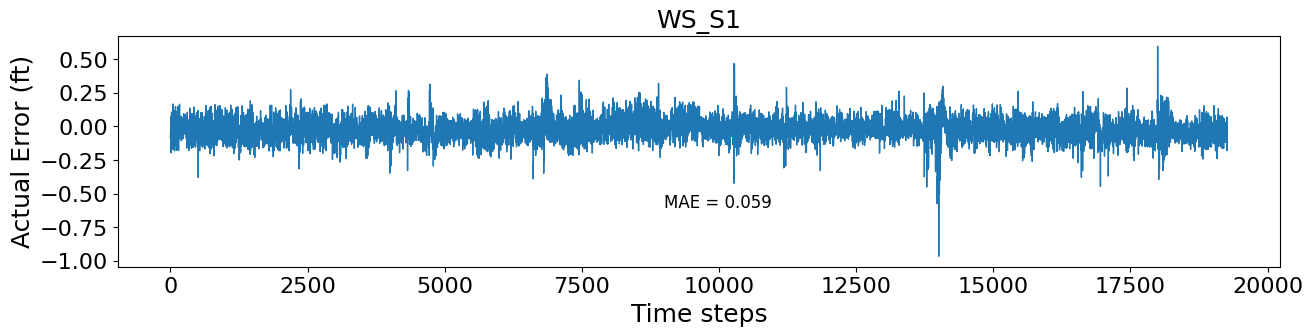

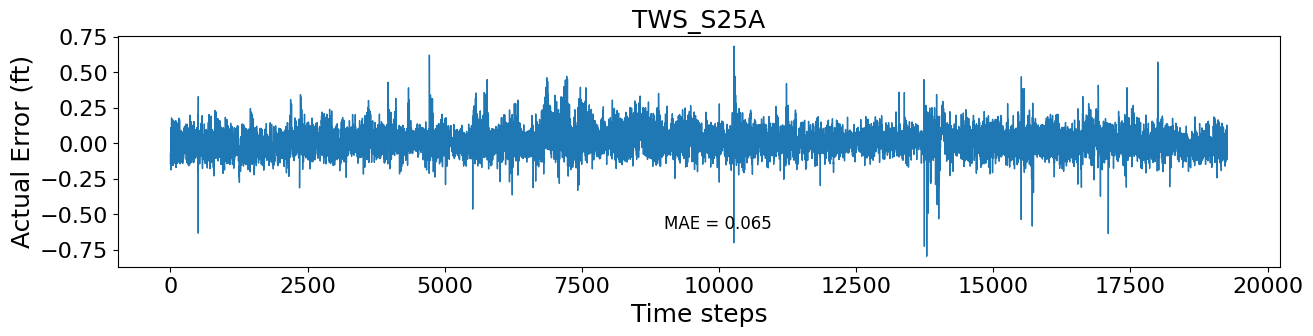

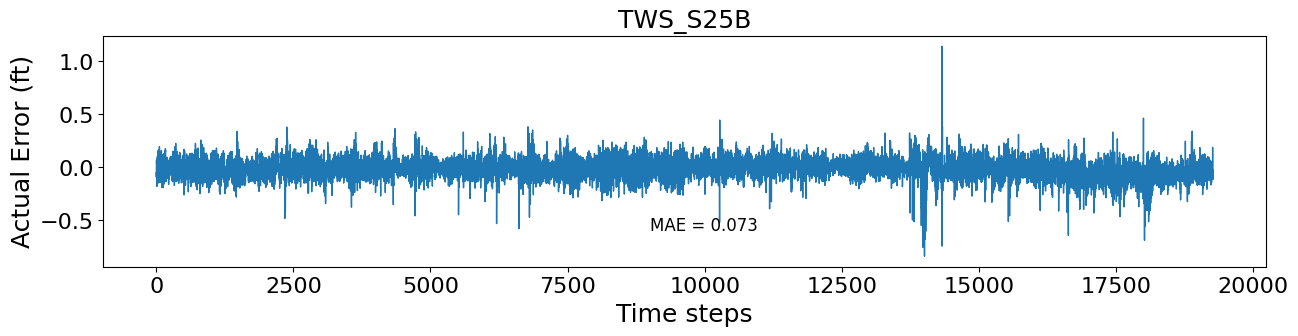

In [ ]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [ ]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

In [ ]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

In [ ]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))